In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
import pickle
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
nturn = 1024
nCore_y = 1
nCore_z = 1

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

pipe_radius = 0.02*np.sqrt(2.0)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
beam.n_particles = 1

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu
lattice[1].pipe_radius = 0.02*np.sqrt(2)

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

TBT = impact.getElem('TBT')
TBT.file_id = nturn
TBT.pID_begin = 1
TBT.pID_end = 1
lattice.insert(1,TBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.file_id = nturn
OUTPUT.turn = nturn
OUTPUT.format_id = 2
lattice.append(OUTPUT)

In [5]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [6]:
data = pickle.load(open('tune_advance.pickle','rb'))
data['pData'].shape

(3067, 6)

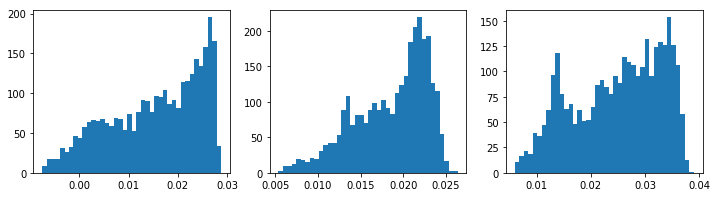

In [7]:
npt = len(data['delta_nux'])
data['dtune'] = np.sqrt(data['delta_nux']**2 + data['delta_nuy']**2)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.hist(data['delta_nux'],bins=40);
plt.subplot(1,3,2)
plt.hist(data['delta_nuy'],bins=40);
plt.subplot(1,3,3)
plt.hist(data['dtune'],bins=40);

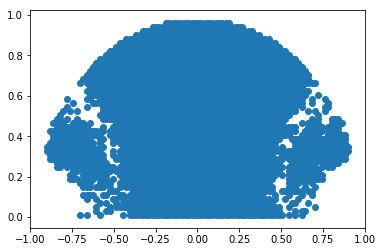

In [8]:
plt.scatter(data['pData'][:,0],data['pData'][:,2])

In [9]:
unnormalize(data['pData'])

(-0.015, 0.015)

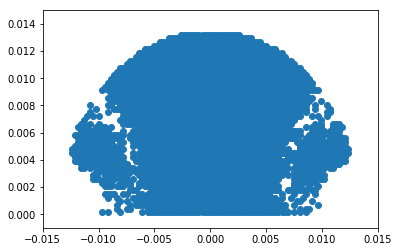

In [10]:
plt.scatter(data['pData'][:,0],data['pData'][:,2])
plt.ylim(-0.001,0.015)
plt.xlim(-0.015,0.015)

In [11]:
lattice[0].turns = nturn

def run(pTest,dx,dy):
    lattice[3].tune_advance_x = dx
    lattice[3].tune_advance_y = dy
    TBT.file_id = nturn
    OUTPUT.file_id = nturn
    
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeParticleData(pTest, ke, mass, freq)
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt0 = impact.readTBT(nturn,ke,mass,freq)
    assert tbt0.shape == (nturn,6,1)
    
    TBT.file_id = nturn*2
    OUTPUT.file_id = nturn*2
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt1 = impact.readTBT(2*nturn,ke,mass,freq)
    assert tbt1.shape == (nturn,6,1)
    
    return tbt0[:,:4,0],tbt1[:,:4,0]

In [ ]:
TBTdata = np.zeros([2*nturn,4,npt])
ipt = 0
for i in range(npt):  
    print(i,ipt)
    pTest = np.zeros([1,9])
    pTest[0,-1] = 1
    pTest[0,-3] = beam.multi_charge.q_m[0]
    pTest[0,:4] = data['pData'][i,:4]
    dx = data['delta_nux'][i]
    dy = data['delta_nuy'][i]
    tmp = run(pTest,dx,dy)
    if tmp:
        TBTdata[:nturn,:,ipt] = tmp[0]
        TBTdata[nturn:,:,ipt] = tmp[1]
        ipt=ipt+1
npt = ipt
TBT=TBTdata[:,:,:npt]

0 0
0
1 0
1
0
2 0
1
1
3 1
1
1
4 2
0
5 2
0
6 2
0
7 2
1
0
8 2
1
1
9 3
1
1
10 4
1
1
11 5
1
1
12 6
1
0
13 6
0
14 6
0
15 6
0
16 6
1
0
17 6
1
1
18 7
1
1
19 8
1
1
20 9
1
1
21 10
1
1
22 11
1
1
23 12
1
1
24 13
1
0
25 13
0
26 13
1
0
27 13
1
0
28 13
0
29 13
0
30 13
1
1
31 14
1
1
32 15
1
1
33 16
1
1
34 17
1
1
35 18
1
1
36 19
1
1
37 20
1
1
38 21
1
1
39 22
1
1
40 23
1
1
41 24
1
1
42 25
1
1
43 26
1
1
44 27
1
1
45 28
1
1
46 29
1
1
47 30
1
1
48 31
1
1
49 32
1
1
50 33
1
1
51 34
1
1
52 35
1
1
53 36
1
1
54 37
1
1
55 38
0
56 38
1
0
57 38
1
1
58 39
1
1
59 40
1
1
60 41
1
1
61 42
1
1
62 43
1
1
63 44
1
1
64 45
1
1
65 46
1
1
66 47
1
1
67 48
1
1
68 49
0
69 49
1
1
70 50
0
71 50
0
72 50
1
1
73 51
1
0
74 51
1
1
75 52
1
1
76 53
1
1
77 54
1
1
78 55
1
1
79 56
1
0
80 56
1
0
81 56
1
0
82 56
1
0
83 56
1
0
84 56
1
1
85 57
1
1
86 58
0
87 58
1
0
88 58
1
0
89 58
1
1
90 59
1
1
91 60
1
1
92 61
1
1
93 62
1
1
94 63
0
95 63
1
0
96 63
1
1
97 64
1
1
98 65
1
1
99 66
1
1
100 67
1
0
101 67
1
1
102 68
1
1
103 69
1
1
104 70
1
0
105 70
1

1
1
711 629
1
1
712 630
1
1
713 631
1
1
714 632
1
1
715 633
1
1
716 634
1
1
717 635
1
1
718 636
1
1
719 637
1
1
720 638
1
1
721 639
1
1
722 640
1
1
723 641
1
1
724 642
1
1
725 643
1
1
726 644
1
1
727 645
1
1
728 646
1
1
729 647
1
1
730 648
1
1
731 649
1
1
732 650
1
1
733 651
1
1
734 652
1
1
735 653
1
1
736 654
1
1
737 655
1
1
738 656
1
1
739 657
1
1
740 658
1
1
741 659
1
1
742 660
1
1
743 661
1
1
744 662
1
1
745 663
1
1
746 664
1
1
747 665
1
1
748 666
1
1
749 667
1
1
750 668
1
1
751 669
1
1
752 670
1
1
753 671
1
1
754 672
1
1
755 673
1
1
756 674
1
1
757 675
1
1
758 676
1
1
759 677
1
1
760 678
1
1
761 679
1
1
762 680
1
1
763 681
1
1
764 682
1
1
765 683
1
1
766 684
1
1
767 685
1
1
768 686
1
1
769 687
1
1
770 688
1
1
771 689
1
1
772 690
1
1
773 691
1
1
774 692
1
1
775 693
1
1
776 694
1
1
777 695
1
1
778 696
1
1
779 697
1
1
780 698
1
1
781 699
1
1
782 700
1
1
783 701
1
1
784 702
1
1
785 703
1
1
786 704
1
1
787 705
1
1
788 706
1
1
789 707
1
1
790 708
1
1
791 709
1
1
792 710
1
1
793 711
1
1


In [46]:
dummy,dummy,npt = TBT.shape

In [47]:
npt

2882

In [48]:
pickle.dump(TBT,open('TBT.basedOnTuneAdvance.Forward.pickle','wb'))

In [63]:
X = (TBT[:,0,:] - 1j*(betx*TBT[:,1,:]+alfx*TBT[:,0,:]))/(NL_c*np.sqrt(betx))
Y = (TBT[:,2,:] - 1j*(betx*TBT[:,3,:]+alfx*TBT[:,2,:]))/(NL_c*np.sqrt(betx))

In [64]:
X.shape

(2048, 2882)

In [65]:
pickle_data = {'X':X,'Y':Y}
pickle.dump(pickle_data,open('basedOnTuneAdvance.dxdy.pickle','wb'))

In [66]:
pickle_data = pickle.load(open('basedOnTuneAdvance.dxdy.pickle','rb'))
X = pickle_data['X']
Y = pickle_data['Y']
dummy,npt = X.shape

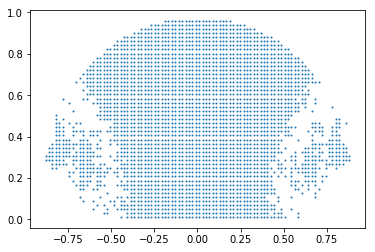

In [68]:
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=1.0)

### Apply NAFF

In [69]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [70]:
tuneXbefore = np.zeros(npt)
tuneYbefore = np.zeros(npt)
Adiff = np.zeros(npt)
for i in range(npt):
    signal = X[:nturn,i] -np.mean(X[:nturn,i])
    tuneXbefore[i],amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = X[nturn:,i] -np.mean(X[nturn:,i])
    tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
    xdiff = getClosestDiff(tuneXbefore[i],tune)

    signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
    tuneYbefore[i],amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
    tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
    ydiff = getClosestDiff(tuneYbefore[i],tune) 
    Adiff[i] = np.log10(np.sqrt(xdiff**2 +ydiff**2)+1.0e-6)

### Plot

##### Tune Plot

In [71]:
def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy

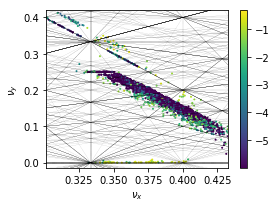

In [72]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)
            
for i in range(-6,6):
    for j in range(-6,6):
        for k in range(-6,6):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)
            
f1=plt.scatter(tuneXbefore,tuneYbefore,c=Adiff,s=1.0,marker='o')

tmp = np.sort(tuneXbefore)
std = 0.2*np.std(tmp)
xmin = tmp[32]-std
xmax = tmp[-32]+std

tmp = np.sort(tuneYbefore)
std = 0.2*np.std(tmp)
ymin = tmp[32]-std
ymax = tmp[-32]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
# plt.savefig('FMA.tune.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu='+str(dTune)+'.png',dpi=180)
# plt.close()

In [73]:
r0_in = 0.7
Arc0yIn = np.linspace(-r0_in,r0_in,100)
Arc0xIn = -np.sqrt(r0_in**2-Arc0yIn**2)
x0in_origin = 1.01


r0_out = 0.7
Arc0yOut = np.linspace(-r0_out,r0_out,100)
Arc0xOut = -np.sqrt(r0_out**2-Arc0yOut**2)
x0out_origin = 1.11

pInArc = np.logical_and( ((np.real(X[0,:])-x0in_origin )**2 + np.real(Y[0,:])**2) > r0_in**2  ,
                         ((np.real(X[0,:])+x0in_origin )**2 + np.real(Y[0,:])**2) > r0_in**2  )
pOutArc= np.logical_or(  ((np.real(X[0,:])-x0out_origin)**2 + np.real(Y[0,:])**2) < r0_out**2 ,
                         ((np.real(X[0,:])+x0out_origin)**2 + np.real(Y[0,:])**2) < r0_out**2 )
pOnArc = np.logical_not( np.logical_or( pInArc, pOutArc))

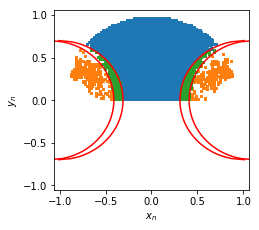

In [74]:
xmax = np.max([np.real(X[0,:]),np.real(Y[0,:])])
plt.figure(figsize=[3.7,3.3])
plt.plot(Arc0xIn   +x0in_origin, Arc0yIn,c='r')
plt.plot(Arc0xOut  +x0out_origin,Arc0yOut,c='r')
plt.plot(-Arc0xIn  -x0in_origin, Arc0yIn,c='r')
plt.plot(-Arc0xOut -x0out_origin,Arc0yOut,c='r')
plt.scatter(np.real(X[0,pInArc]),np.real(Y[0,pInArc]),s=1.6,marker='s')
plt.scatter(np.real(X[0,pOutArc]),np.real(Y[0,pOutArc]),s=1.6,marker='s')
plt.scatter(np.real(X[0,pOnArc]),np.real(Y[0,pOnArc]),s=1.6,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.tight_layout()

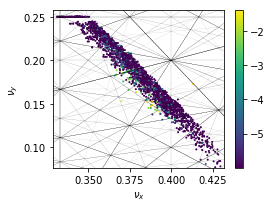

In [75]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)
            
for i in range(-6,6):
    for j in range(-6,6):
        for k in range(-6,6):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)

            
f1=plt.scatter(tuneXbefore[pInArc],tuneYbefore[pInArc],c=Adiff[pInArc],s=1.0,marker='o')

if NL_nu==0.28:
    nux,nuy = resonnace(3,0,1)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.34, 0.07, r'$3\nu_x=1$', fontsize=11, color='r', rotation=90, rotation_mode='anchor')
    nux,nuy = resonnace(1,2,0)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.362, 0.188, r'$2\nu_y-\nu_x=0$', fontsize=11, color='r', rotation=15, rotation_mode='anchor')
    nux,nuy = resonnace(-2,2,1)
    plt.plot(nux,nuy,c='r',lw=0.8,ls='--')
    plt.text(0.301, 0.187, r'$2\nu_x+2\nu_y=1$', fontsize=11, color='r', rotation=-30, rotation_mode='anchor')


tmp = np.sort(tuneXbefore[pInArc])
std = 0.2*np.std(tmp)
xmin = tmp[8]-std
xmax = tmp[-8]+std

tmp = np.sort(tuneYbefore[pInArc])
std = 0.2*np.std(tmp)
ymin = tmp[8]-std
ymax = tmp[-8]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
plt.savefig('FMA.tune.regionI.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.png',dpi=180)

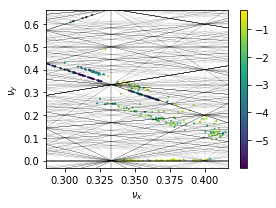

In [76]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)
            
for i in range(-6,6):
    for j in range(-6,6):
        for k in range(-6,6):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)
            
            
f1=plt.scatter(tuneXbefore[pOutArc],tuneYbefore[pOutArc],c=Adiff[pOutArc],s=1.0,marker='o')

tmp = np.sort(tuneXbefore[pOutArc])
std = 0.2*np.std(tmp)
xmin = tmp[8]-std
xmax = tmp[-8]+std

tmp = np.sort(tuneYbefore[pOutArc])
std = 0.2*np.std(tmp)
ymin = tmp[8]-std
ymax = tmp[-8]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
plt.savefig('FMA.tune.regionII.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.png',dpi=180)

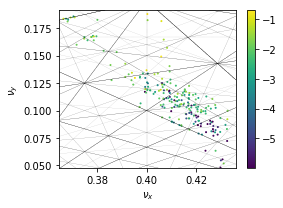

In [77]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)
            
for i in range(-6,6):
    for j in range(-6,6):
        for k in range(-6,6):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)
            
            
f1=plt.scatter(tuneXbefore[pOnArc],tuneYbefore[pOnArc],c=Adiff[pOnArc],s=1.0,marker='o')

tmp = np.sort(tuneXbefore[pOnArc])
std = 0.2*np.std(tmp)
xmin = tmp[8]-std
xmax = tmp[-8]+std

tmp = np.sort(tuneYbefore[pOnArc])
std = 0.2*np.std(tmp)
ymin = tmp[8]-std
ymax = tmp[-8]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
plt.savefig('FMA.tune.regionIII.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.png',dpi=180)

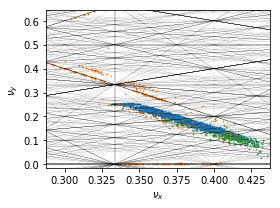

In [78]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--',alpha=0.7)
            
for i in range(-6,6):
    for j in range(-6,6):
        for k in range(-6,6):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.1,ls='--',alpha=0.7)
            
            
plt.scatter(tuneXbefore[pInArc],tuneYbefore[pInArc],s=0.5,marker='o',alpha=0.8)
plt.scatter(tuneXbefore[pOutArc],tuneYbefore[pOutArc],s=0.5,marker='o',alpha=0.8)
plt.scatter(tuneXbefore[pOnArc],tuneYbefore[pOnArc],s=0.5,marker='o',alpha=0.8)

tmp = np.sort(tuneXbefore)
std = 0.2*np.std(tmp)
xmin = tmp[8]-std
xmax = tmp[-8]+std

tmp = np.sort(tuneYbefore)
std = 0.2*np.std(tmp)
ymin = tmp[8]-std
ymax = tmp[-8]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
plt.savefig('FMA.tune.regions.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.png',dpi=180)

##### Poincare

##### DA

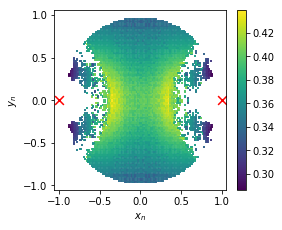

In [79]:
xmax = np.max([np.real(X[0,:]),np.real(Y[0,:])])
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=tuneXbefore,s=1.6,marker='s')
plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=tuneXbefore,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA.nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',dpi=180)

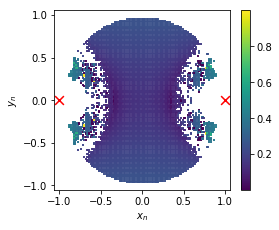

In [80]:
xmax = np.max([np.real(X[0,:]),np.real(Y[0,:])])
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=tuneYbefore,s=1.6,marker='s')
plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=tuneYbefore,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA.nuy.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',dpi=180)

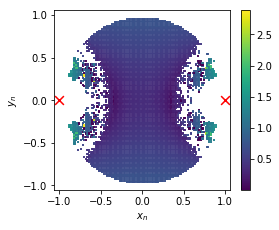

In [81]:
xmax = np.max([np.real(X[0,:]),np.real(Y[0,:])])
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=tuneYbefore/tuneXbefore,s=1.6,marker='s')
plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=tuneYbefore/tuneXbefore,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA.nuy_nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',dpi=180)

In [82]:
import pickle
with open('tuneContourData','rb') as f:
    data = pickle.load(f)

In [83]:
class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s

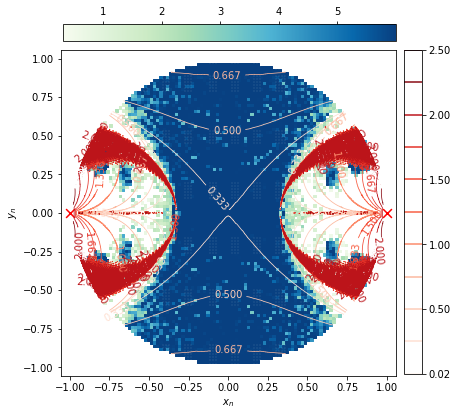

In [84]:
fig = plt.figure(figsize=[6,6])
f1=plt.scatter(np.real(X[0,:]), np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f1=plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f2=plt.tricontour(data['X0'],data['Y0'],data['nu_y']/data['nu_x'],
              levels=[0.02,1/3,1/2,2/3,1,4/3,3/2,5/3,2,7/3,5/2,8/3,3],
              cmap = 'Reds')
f2.levels = [nf(val) for val in f2.levels]
plt.clabel(f2, f2.levels, fontsize=10)
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
cax1 = fig.add_axes([0.13, 0.9, 0.77, 0.04])
cb1 = plt.colorbar(f1,orientation='horizontal', cax=cax1)
cax1.xaxis.set_label_position('top')
cax1.xaxis.set_ticks_position('top')
plt.setp(f2.collections , linewidth=0.75)
cax2 = fig.add_axes([0.92, 0.13, 0.04, 0.75])
plt.colorbar(f2,drawedges=False, cax=cax2)
plt.savefig('FMA.DA_tune.nuy_nu_x.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',
            dpi=180, bbox_inches = "tight")

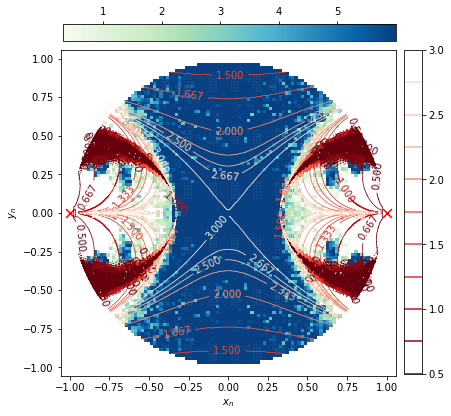

In [85]:
fig = plt.figure(figsize=[6,6])
f1=plt.scatter(np.real(X[0,:]), np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f1=plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f2=plt.tricontour(data['X0'],data['Y0'],data['nu_x']/data['nu_y'],
              levels=[0.02,1/3,1/2,2/3,1,4/3,3/2,5/3,2,7/3,5/2,8/3,3],
              cmap = 'Reds_r')
f2.levels = [nf(val) for val in f2.levels]
plt.clabel(f2, f2.levels, fontsize=10)
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
cax1 = fig.add_axes([0.13, 0.9, 0.77, 0.04])
cb1 = plt.colorbar(f1,orientation='horizontal', cax=cax1)
cax1.xaxis.set_label_position('top')
cax1.xaxis.set_ticks_position('top')
plt.setp(f2.collections , linewidth=0.75)
cax2 = fig.add_axes([0.92, 0.13, 0.04, 0.75])
plt.colorbar(f2,drawedges=False, cax=cax2)
plt.savefig('FMA.DA_tune.nux_nu_y.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',
            dpi=180, bbox_inches = "tight")

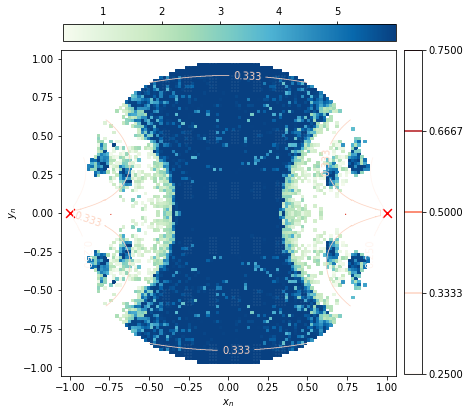

In [86]:
fig = plt.figure(figsize=[6,6])
f1=plt.scatter(np.real(X[0,:]), np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f1=plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f2=plt.tricontour(data['X0'],data['Y0'],data['nu_x'],
              levels=[0.02,1/4,1/3,1/2,2/3,3/4,1.0-0.02],
              cmap = 'Reds')
f2.levels = [nf(val) for val in f2.levels]
plt.clabel(f2, f2.levels, fontsize=10)
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
cax1 = fig.add_axes([0.13, 0.9, 0.77, 0.04])
cb1 = plt.colorbar(f1,orientation='horizontal', cax=cax1)
cax1.xaxis.set_label_position('top')
cax1.xaxis.set_ticks_position('top')
plt.setp(f2.collections , linewidth=0.75)
cax2 = fig.add_axes([0.92, 0.13, 0.04, 0.75])
plt.colorbar(f2,drawedges=False, cax=cax2)
plt.savefig('FMA.DA_tune.nux.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',
            dpi=180, bbox_inches = "tight")

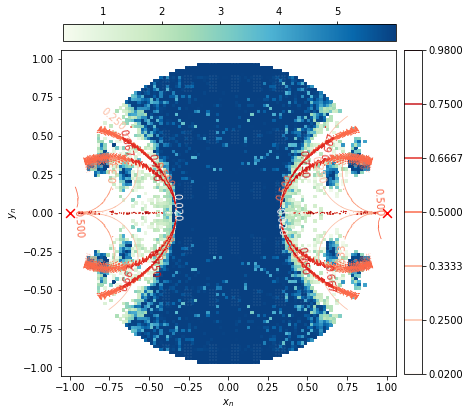

In [87]:
fig = plt.figure(figsize=[6,6])
f1=plt.scatter(np.real(X[0,:]), np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f1=plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=-Adiff,s=7.4,marker='s',cmap='GnBu')
f2=plt.tricontour(data['X0'],data['Y0'],data['nu_y'],
              levels=[0.02,1/4,1/3,1/2,2/3,3/4,1.0-0.02],
              cmap = 'Reds')
f2.levels = [nf(val) for val in f2.levels]
plt.clabel(f2, f2.levels, fontsize=10)
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
cax1 = fig.add_axes([0.13, 0.9, 0.77, 0.04])
cb1 = plt.colorbar(f1,orientation='horizontal', cax=cax1)
cax1.xaxis.set_label_position('top')
cax1.xaxis.set_ticks_position('top')
plt.setp(f2.collections , linewidth=0.75)
cax2 = fig.add_axes([0.92, 0.13, 0.04, 0.75])
plt.colorbar(f2,drawedges=False, cax=cax2)
plt.savefig('FMA.DA_tune.nuy.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',
            dpi=180, bbox_inches = "tight")

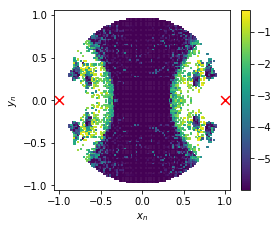

In [88]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]), np.real(Y[0,:]),c=Adiff,s=1.6,marker='s')
f1=plt.scatter(np.real(X[0,:]),-np.real(Y[0,:]),c=Adiff,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.DA.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',dpi=180)


# FB

### Run Backward

In [89]:
lattice[-1].file_id = nturn
lattice[-1]


          type: 'write_raw_ptcl'
       file_id: 1024
     format_id: 2
          turn: 1024
 sample_period: 1

In [90]:
lattice[1].file_id = nturn
lattice[1]


      type: 'TBT'
   file_id: 1024
 pID_begin: 1
   pID_end: 1

In [91]:
latticeB = copy(lattice[1:-1][::-1])
latticeB.insert(0,copy(lattice[0]))

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        latticeB[i].tune_advance                 =-latticeB[i].tune_advance
        latticeB[i].nonlinear_insert_tuneAdvance =-latticeB[i].nonlinear_insert_tuneAdvance
        latticeB[i].nonlinear_insert_length      =-latticeB[i].nonlinear_insert_length

In [92]:
for item in lattice:
    print(item.type)

loop
TBT
nonlinear_insert
linear_matrix_map
write_raw_ptcl


In [93]:
for item in latticeB:
    print(item.type)

loop
linear_matrix_map
nonlinear_insert
TBT


In [94]:
def run(pTest,dx,dy):
    lattice[3].tune_advance_x = dx
    lattice[3].tune_advance_y = dy
    latticeB[1].tune_advance_x = -dx
    latticeB[1].tune_advance_y = -dy
    

    beam.distribution.distribution_type = 'ReadFile'
    impact.writeParticleData(pTest, ke, mass, freq)
    impact.writeInputFile(beam,lattice) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt0 = impact.readTBT(nturn,ke,mass,freq)
    assert tbt0.shape == (nturn,6,1)
    
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = nturn
    impact.writeInputFile(beam,latticeB) 
    impact.run(beam)
    print(impact.readLostAt(-1))
    if impact.readLostAt(-1) == 0:
        return False
    tmp,tbt1 = impact.readTBT(nturn,ke,mass,freq)
    assert tbt1.shape == (nturn,6,1)
    
    return tbt0[:,:4,0],tbt1[::-1,:4,0]

In [95]:
data = pickle.load(open('tune_advance.pickle','rb'))
npt = len(data['delta_nux'])
data['dtune'] = np.sqrt(data['delta_nux']**2 + data['delta_nuy']**2)

In [96]:
unnormalize(data['pData'])

In [ ]:
TBTF = np.zeros([nturn,4,npt])
TBTB = np.zeros([nturn,4,npt])
ipt = 0
for i in range(npt):  
    print(i,ipt)
    pTest = np.zeros([1,9])
    pTest[0,-1] = 1
    pTest[0,-3] = beam.multi_charge.q_m[0]
    pTest[0,:4] = data['pData'][i,:4]
    dx = data['delta_nux'][i]
    dy = data['delta_nuy'][i]
    tmp = run(pTest,dx,dy)
    if tmp:
        TBTF[:,:,ipt] = tmp[0]
        TBTB[:,:,ipt] = tmp[1]
        ipt=ipt+1
npt = ipt

0 0
0
1 0
1
0
2 0
1
1
3 1
1
1
4 2
0
5 2
0
6 2
0
7 2
1
0
8 2
1
1
9 3
1
1
10 4
1
1
11 5
1
1
12 6
1
1
13 7
0
14 7
0
15 7
0
16 7
1
1
17 8
1
1
18 9
1
1
19 10
1
1
20 11
1
1
21 12
1
1
22 13
1
1
23 14
1
1
24 15
1
1
25 16
0
26 16
1
1
27 17
1
0
28 17
0
29 17
0
30 17
1
1
31 18
1
1
32 19
1
1
33 20
1
1
34 21
1
1
35 22
1
1
36 23
1
1
37 24
1
1
38 25
1
1
39 26
1
1
40 27
1
1
41 28
1
1
42 29
1
1
43 30
1
1
44 31
1
1
45 32
1
1
46 33
1
1
47 34
1
1
48 35
1
1
49 36
1
1
50 37
1
1
51 38
1
1
52 39
1
1
53 40
1
1
54 41
1
1
55 42
0
56 42
1
1
57 43
1
1
58 44
1
1
59 45
1
1
60 46
1
1
61 47
1
1
62 48
1
1
63 49
1
1
64 50
1
1
65 51
1
1
66 52
1
1
67 53
1
1
68 54
0
69 54
1
0
70 54
0
71 54
0
72 54
1
0
73 54
1
1
74 55
1
1
75 56
1
1
76 57
1
1
77 58
1
1
78 59
1
1
79 60
1
1
80 61
1
0
81 61
1
0
82 61
1
1
83 62
1
1
84 63
1
0
85 63
1
0
86 63
0
87 63
1
0
88 63
1
0
89 63
1
1
90 64
1
1
91 65
1
1
92 66
1
0
93 66
1
1
94 67
0
95 67
1
0
96 67
1
1
97 68
1
0
98 68
1
0
99 68
1
1
100 69
1
0
101 69
1
1
102 70
1
1
103 71
1
1
104 72
1
0
105 72

1
1
711 632
1
1
712 633
1
1
713 634
1
1
714 635
1
1
715 636
1
1
716 637
1
1
717 638
1
1
718 639
1
1
719 640
1
1
720 641
1
1
721 642
1
1
722 643
1
1
723 644
1
1
724 645
1
1
725 646
1
1
726 647
1
1
727 648
1
1
728 649
1
1
729 650
1
1
730 651
1
1
731 652
1
1
732 653
1
1
733 654
1
1
734 655
1
1
735 656
1
1
736 657
1
1
737 658
1
1
738 659
1
1
739 660
1
1
740 661
1
1
741 662
1
1
742 663
1
1
743 664
1
1
744 665
1
1
745 666
1
1
746 667
1
1
747 668
1
1
748 669
1
1
749 670
1
1
750 671
1
1
751 672


In [ ]:
TBTF=TBTF[:,:,:npt]
TBTB=TBTB[:,:,:npt]

In [ ]:
XF = (TBTF[:,0,:] - 1j*(betx*TBTF[:,1,:]+alfx*TBTF[:,0,:]))/(NL_c*np.sqrt(betx))
YF = (TBTF[:,2,:] - 1j*(betx*TBTF[:,3,:]+alfx*TBTF[:,2,:]))/(NL_c*np.sqrt(betx))

In [ ]:
XB = (TBTB[:,0,:] - 1j*(betx*TBTB[:,1,:]+alfx*TBTB[:,0,:]))/(NL_c*np.sqrt(betx))
YB = (TBTB[:,2,:] - 1j*(betx*TBTB[:,3,:]+alfx*TBTB[:,2,:]))/(NL_c*np.sqrt(betx))

In [ ]:
plt.plot(TBTF[-22:-1,0,2])
plt.plot(TBTB[-22:-1,0,2])

In [ ]:
Adiff = np.abs(XF-XB)**2+np.abs(YF-YB)**2
Adiff = np.log10(np.sqrt(np.sum(Adiff,0)/nturn))

### Plot

##### DA

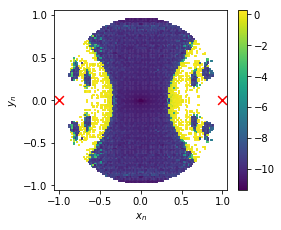

In [104]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(XF[0,:]), np.real(YF[0,:]),c=Adiff,s=1.6,marker='s')
f1=plt.scatter(np.real(XF[0,:]),-np.real(YF[0,:]),c=Adiff,s=1.6,marker='s')
plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FB.DA.nu='+str(NL_nu)+'.tau='+str(NL_t)+'.mu=measured_dxdy.turn=1024.png',dpi=180)